# importacion de librerias

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score
from pickle import dump
import pickle
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

# lectura del dataframe

In [50]:
df = pd.read_csv("/workspaces/betaniammc-machine-learning/data/processed/df_diabetes")


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               767 non-null    int64  
 1   Glucose                   767 non-null    float64
 2   BloodPressure             767 non-null    float64
 3   SkinThickness             767 non-null    float64
 4   Insulin                   767 non-null    float64
 5   BMI                       767 non-null    float64
 6   DiabetesPedigreeFunction  767 non-null    float64
 7   Age                       767 non-null    int64  
 8   Outcome                   767 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


# split

In [52]:
# Dividimos el conjunto de datos en muestras de train y test
X = df.drop(["Outcome"], axis=1)
y = df["Outcome"]

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

# primera estimacion de todos los modelos

In [53]:
xgb = XGBClassifier(n_estimators=200,
                    learning_rate=0.1,
                    random_state=18,
                    use_label_encoder=False,
                    eval_metric='mlogloss')
ada = AdaBoostClassifier(n_estimators=200,
                         learning_rate=0.1,
                         random_state=18)
gb = GradientBoostingClassifier(n_estimators=200,
                                learning_rate=0.1,
                                random_state=18)
lgb = LGBMClassifier(n_estimators=200,
                     learning_rate=0.1,
                     random_state=18)

In [54]:
xgb.fit(X_train, y_train)
ada.fit(X_train, y_train)
gb.fit(X_train, y_train)
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 214, number of negative: 399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 613, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349103 -> initscore=-0.622985
[LightGBM] [Info] Start training from score -0.622985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [55]:
# predicción
ada_y_pred_test = ada.predict(X_test)
gb_y_pred_test = gb.predict(X_test)
xgb_y_pred_test = xgb.predict(X_test)
lgb_y_pred_test = lgb.predict(X_test)

ada_y_pred_train = ada.predict(X_train)
gb_y_pred_train = gb.predict(X_train)
xgb_y_pred_train = xgb.predict(X_train)
lgb_y_pred_train = lgb.predict(X_train)

In [56]:
accuracy_train = (accuracy_score(y_train, ada_y_pred_train),
                  accuracy_score(y_train, gb_y_pred_train),
                  accuracy_score(y_train, xgb_y_pred_train),
                  accuracy_score(y_train, lgb_y_pred_train))
accuracy_test = (accuracy_score(y_test, ada_y_pred_test),
                 accuracy_score(y_test, gb_y_pred_test),
                 accuracy_score(y_test, xgb_y_pred_test),
                 accuracy_score(y_test, lgb_y_pred_test))

accuracy = pd.DataFrame(data=[accuracy_train, accuracy_test],
                        columns=['AdaBoost', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
                        index=['Train set', 'Test set'])

accuracy

,AdaBoost,Gradient Boosting,XGBoost,LightGBM
Train set,0.771615,0.977162,1.00000,1.00000
Test set,0.753247,0.805195,0.74026,0.75974


se tienen altos niveles de overfitting en el modelo por lo cual se procede a realizar el ajuste de los parametros usando los siguientes modelos

# ajuste de cada modelo

# AdaBoost

In [57]:
# Definimos los parámetros que queremos ajustar a mano
hyperparams = {'n_estimators': [ 20, 60, 70, 80] ,
               'learning_rate': [1.0, 2.0, 3.0]
                }



# Inicializamos la cuadrícula
grid_diabetes = GridSearchCV(AdaBoostClassifier(random_state=18),
                    hyperparams,
                    cv=5,
                    n_jobs=-1,
                    verbose=1)
grid_diabetes.fit(X_train, y_train)

grid_diabetes.best_params_  

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'learning_rate': 1.0, 'n_estimators': 80}

In [58]:
ada = AdaBoostClassifier(n_estimators= 80,  random_state = 18)
ada.fit(X_train, y_train)
ada_y_pred_test = ada.predict(X_test)
ada_y_pred_train = ada.predict(X_train)
accuracy_score(y_test, ada_y_pred_test), accuracy_score(y_train, ada_y_pred_train)

(0.8181818181818182, 0.802610114192496)

# Gradient Boosting

In [59]:
# Definimos los parámetros que queremos ajustar a mano
hyperparams = {'n_estimators': [ 10, 20, 30] ,
               'learning_rate': [1.0, 2.0, 3.0]
                }



# Inicializamos la cuadrícula
grid_diabetes = GridSearchCV(GradientBoostingClassifier(random_state=18),
                    hyperparams,
                    cv=5,
                    n_jobs=-1,
                    verbose=1)
grid_diabetes.fit(X_train, y_train)

grid_diabetes.best_params_  

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'learning_rate': 1.0, 'n_estimators': 20}

In [60]:
gb = GradientBoostingClassifier(n_estimators= 20,  random_state = 18)
gb.fit(X_train, y_train)
gb_y_pred_test = gb.predict(X_test)
gb_y_pred_train = gb.predict(X_train)
accuracy_score(y_test, gb_y_pred_test), accuracy_score(y_train, gb_y_pred_train)

(0.7987012987012987, 0.8254486133768353)

# XGB  eXtreme Gradient Boost

In [61]:
# Definimos los parámetros que queremos ajustar a mano
hyperparams = {'n_estimators': [ 2,5,10] ,
               'learning_rate': [1.0, 2.0, 3.0],
               'max_depth' : [4, 5, 6 , 8 ]
                }



# Inicializamos la cuadrícula
grid_diabetes = GridSearchCV(XGBClassifier(random_state=18),
                    hyperparams,
                    cv=5,
                    n_jobs=-1,
                    verbose=1)
grid_diabetes.fit(X_train, y_train)

grid_diabetes.best_params_  

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 10}

In [62]:
xgb = XGBClassifier(n_estimators=10, max_depth=4, random_state=18)
xgb.fit(X_train, y_train)
xgb_y_pred_test = xgb.predict(X_test)
xgb_y_pred_train = xgb.predict(X_train)
accuracy_score(y_test, xgb_y_pred_test), accuracy_score(y_train, xgb_y_pred_train)

(0.7987012987012987, 0.8417618270799347)

# LGBMClassifier

In [63]:
# Definimos los parámetros que queremos ajustar a mano
hyperparams = {'n_estimators': [20, 30, 40] ,
               'learning_rate': [1.0, 2.0, 3.0],
               'max_depth' : [4,5,6]
                }



# Inicializamos la cuadrícula
grid_diabetes = GridSearchCV(LGBMClassifier(random_state=42),
                    hyperparams,
                    cv=5,
                    n_jobs=-1,
                    verbose=1)
grid_diabetes.fit(X_train, y_train)

grid_diabetes.best_params_  

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 171, number of negative: 319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 490, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348980 -> initscore=-0.623528
[LightGBM] [Info] Start training from score -0.623528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves

{'learning_rate': 1.0, 'max_depth': 6, 'n_estimators': 30}

In [64]:
model_LGBMClassifier = LGBMClassifier(n_estimators=30, max_depth=6, random_state=42)
model_LGBMClassifier.fit(X_train, y_train)
y_pred_test = model_LGBMClassifier.predict(X_test)
y_pred_train = model_LGBMClassifier.predict(X_train)
accuracy_score(y_test, y_pred_test), accuracy_score(y_train, y_pred_train)

[LightGBM] [Info] Number of positive: 214, number of negative: 399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 613, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349103 -> initscore=-0.622985
[LightGBM] [Info] Start training from score -0.622985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

(0.7922077922077922, 0.8841761827079935)

In [65]:
lgb = LGBMClassifier(n_estimators=20, max_depth=4, random_state=18)
lgb.fit(X_train, y_train)
lgb_y_pred_test = lgb.predict(X_test)
lgb_y_pred_train = lgb.predict(X_train)
accuracy_score(y_test, lgb_y_pred_test), accuracy_score(y_train, lgb_y_pred_train)

[LightGBM] [Info] Number of positive: 214, number of negative: 399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 613, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349103 -> initscore=-0.622985
[LightGBM] [Info] Start training from score -0.622985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

(0.7857142857142857, 0.8270799347471451)

# Random forest

Resultados de random forest

In [66]:
rf = RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=11, n_estimators= 20, random_state = 42)
rf.fit(X_train, y_train)
rf_y_pred_test = rf.predict(X_test)
rf_y_pred_train = rf.predict(X_train)
accuracy_score(y_test, rf_y_pred_test), accuracy_score(y_train, rf_y_pred_train)

(0.8246753246753247, 0.8743882544861338)

# resultado de todos los modelos despues de ajustar parametros

In [67]:
accuracy_train = (accuracy_score(y_train, ada_y_pred_train),
                  accuracy_score(y_train, gb_y_pred_train),
                  accuracy_score(y_train, xgb_y_pred_train),
                  accuracy_score(y_train, lgb_y_pred_train),
                  accuracy_score(y_train, rf_y_pred_train))

accuracy_test = (accuracy_score(y_test, ada_y_pred_test),
                 accuracy_score(y_test, gb_y_pred_test),
                 accuracy_score(y_test, xgb_y_pred_test),
                 accuracy_score(y_test, lgb_y_pred_test),
                 accuracy_score(y_test, rf_y_pred_test))

accuracy = pd.DataFrame(data=[accuracy_train, accuracy_test],
                        columns=['AdaBoost', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'RandomForest'],
                        index=['Train set', 'Test set'])

accuracy

,AdaBoost,Gradient Boosting,XGBoost,LightGBM,RandomForest
Train set,0.802610,0.825449,0.841762,0.827080,0.874388
Test set,0.818182,0.798701,0.798701,0.785714,0.824675


# Matriz de confusion ada

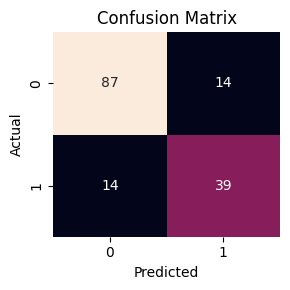

In [68]:
caso_diabetes = confusion_matrix(y_test, ada_y_pred_test)

# Dibujaremos esta matriz para hacerla más visual
df_cm = pd.DataFrame(caso_diabetes)

plt.figure(figsize=(3, 3))
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

Observaciones

el modelo ha predicho correctamente 87 negativos

el modelo ha predicho erroneamente 14 negativos que en realidad eran verdaderos

el modelo ha predicho correctamente 39 posivos

el modelo ha predicho erroneamente 14 positivos que en realidad eran negativos

In [69]:
# Matriz de confusion gradient boosting

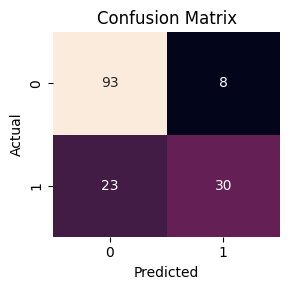

In [70]:
caso_diabetes = confusion_matrix(y_test, gb_y_pred_test)

# Dibujaremos esta matriz para hacerla más visual
df_cm = pd.DataFrame(caso_diabetes)

plt.figure(figsize=(3, 3))
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

Observaciones

el modelo ha predicho correctamente 93 negativos

el modelo ha predicho erroneamente 23 negativos que en realidad eran verdaderos

el modelo ha predicho correctamente 30 posivos

el modelo ha predicho erroneamente 8 positivos que en realidad eran negativos

Matriz confusion XGB

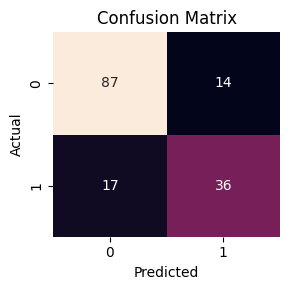

In [71]:
caso_diabetes = confusion_matrix(y_test, xgb_y_pred_test)

# Dibujaremos esta matriz para hacerla más visual
df_cm = pd.DataFrame(caso_diabetes)

plt.figure(figsize=(3, 3))
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

Observaciones

el modelo ha predicho correctamente 87 negativos

el modelo ha predicho erroneamente 17 negativos que en realidad eran verdaderos

el modelo ha predicho correctamente 36 posivos

el modelo ha predicho erroneamente 14 positivos que en realidad eran negativos

# Matriz confusion LGB 

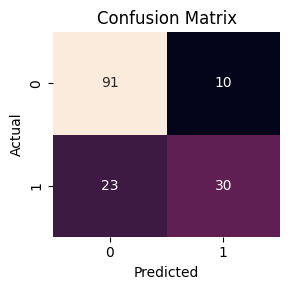

In [72]:
caso_diabetes = confusion_matrix(y_test, lgb_y_pred_test)

# Dibujaremos esta matriz para hacerla más visual
df_cm = pd.DataFrame(caso_diabetes)

plt.figure(figsize=(3, 3))
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

Observaciones

el modelo ha predicho correctamente 91 negativos

el modelo ha predicho erroneamente 23 negativos que en realidad eran verdaderos

el modelo ha predicho correctamente 30 posivos

el modelo ha predicho erroneamente 10 positivos que en realidad eran negativos

# Matriz confusion Random forest

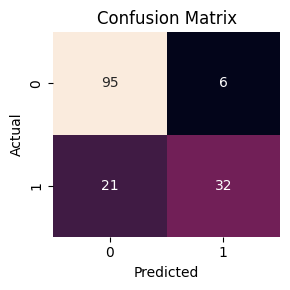

In [73]:
caso_diabetes = confusion_matrix(y_test, rf_y_pred_test)

# Dibujaremos esta matriz para hacerla más visual
df_cm = pd.DataFrame(caso_diabetes)

plt.figure(figsize=(3, 3))
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

Observaciones

el modelo ha predicho correctamente 95 negativos

el modelo ha predicho erroneamente 21 negativos que en realidad eran verdaderos

el modelo ha predicho correctamente 32 posivos

el modelo ha predicho erroneamente 6 positivos que en realidad eran negativos

# Conclusion:

Se acepta el modelo Ada como mejor modelo ya que:

el modelo ha predicho correctamente 87 negativos

el modelo ha predicho erroneamente 14 negativos que en realidad eran verdaderos

el modelo ha predicho correctamente 39 posivos

el modelo ha predicho erroneamente 14 positivos que en realidad eran negativos

como se ha mencionado en proyectos anteriores en este tipo de estudio es preferible obtener resultados donde sean mas acertados los casos de diabetes ya que es preferible tener un falso posivo y analizar a personas que no tienen la enfermedad, ante la prediccion erronea de falsos negativos en donde se dejan por fuera a las personas que realmente tienen la enfermedad.

los dos modelos menos certados han sido gradiente boosting y lgb ya que solo han acertado con 30 positivos para personas que tenian diabetes y han marcado como negativo a 23 personas que realmente tenian diabetes.